In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import torch 
from pyscf import gto, scf
import numpy as np
from pyscf import gto, scf
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh,eigs
import scipy.linalg as la
from qiskit.circuit.library import RZGate, RXGate, RXXGate
import scipy.sparse as sp
import torch.nn.init as init
import sbovqaopt
import math



warnings.filterwarnings('ignore')

In [2]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 


def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(hamiltonian_matrix)
print(len(hamiltonian_matrix))


tensor([[-0.7429+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j, -0.7970+0.0000j,  0.2495+0.0047j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.2495-0.0047j, -0.4701+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        ...,
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -0.4701+0.0000j, -0.2495-0.0047j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -0.2495+0.0047j, -0.7970+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j, -0.7429+0.0000j]],
       dtype=torch.complex128)
256


In [3]:
# Define the classical encoder neural network
class ClassicalEncoder(nn.Module):
    def __init__(self):
        super(ClassicalEncoder, self).__init__()
        self.fc = nn.Sequential(
            #nn.Linear(4096, 32),
            #nn.ReLU(),
            #nn.Linear(2048, 1024),
            #nn.ReLU(),
            #nn.Linear(1024, 512),
            #nn.ReLU(),
            #nn.Linear(512, 256),
            #nn.ReLU(),
            nn.Linear(256, 128),  # First layer with 7 inputs and 14 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(128, 64), # Second layer with 14 inputs and 28 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(64, 32), # Third layer with 28 inputs and 56 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(32,16),
            #nn.ReLU(),
            #nn.Linear(16, 8), # Fourth layer reducing from 56 to 28 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(8, 4), # Fifth layer reducing from 28 to 14 outputs
            #nn.ReLU(),
            #nn.Linear(4,1)
        )
    
    def forward(self, x):
        return self.fc(x)

encoder = ClassicalEncoder()
#print("The encoder is: ", encoder)

class QuantumCircuitModule:
    def __init__(self, num_qubits, depth):
        super(QuantumCircuitModule, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.params = torch.nn.Parameter(torch.rand((3 * num_qubits * depth + depth * (num_qubits - 1)), dtype=torch.float32) * 0.01)  # Small random initialization
        
        # Create a list of parameters for the quantum circuit, with correlations for avoiding barren plateaus
        self.theta = [Parameter(f'θ{i}') for i in range(len(self.params))]

    def forward(self, x):
        # Initialize the quantum circuit
        backend=Aer.get_backend('qasm_simulator')
        qc = QuantumCircuit(self.num_qubits, self.num_qubits)

        param_counter = 0
        
        y= x.detach().numpy()

        norm = np.sqrt(np.sum(np.abs(y)**2))
        if norm == 0:
            raise ValueError("Cannot normalize the zero vector")
        y = y / norm
        #y= math.ceil(y)

        qc.initialize(y,[i for i in range(num_qubits)])
        # Apply initial rotations with a careful initialization

        qc
        

        for layer in range(self.depth):
            # Add rotation layers
            for qubit in range(self.num_qubits):
                qc.rz(self.theta[param_counter], qubit)
                param_counter += 1
                qc.rx(self.theta[param_counter], qubit)
                param_counter += 1
                qc.rz(self.theta[param_counter], qubit)
                param_counter += 1
            
            # Add the entangling RXX gates in a pattern to increase entanglement gradually
            for qubit in range(self.num_qubits - 1):
                qc.rxx(self.theta[param_counter], qubit, (qubit + 1) % self.num_qubits)
                param_counter += 1

            # Add barrier to define layers clearly
        qc.barrier()

        # Add measurements
        qc.measure(range(self.num_qubits), range(self.num_qubits))
        #print(qc.draw('text'))

        # Bind the parameters to the values from the input
        param_values = [p.item() for p in self.params]
        qc_bound = qc.bind_parameters({self.theta[i]: param_values[i] for i in range(len(self.params))})

        # Execute the quantum circuit
        transpiled_circuit = transpile(qc_bound, backend)
        job = execute(transpiled_circuit, backend, shots=2048)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)

        expectation_values = []
        for i in range(num_qubits):
            # Calculate expectation value for each qubit
            p0 = counts.get('0' * i + '0' + '0' * (3 - i), 0) / 1024
            p1 = counts.get('0' * i + '1' + '0' * (3 - i), 0) / 1024
            expectation_value = p0 - p1
            expectation_values.append(expectation_value)

        # Convert the most common bitstring to numpy array and then to PyTorch tensor
        output_bitstring = max(counts, key=counts.get)
        output_data = np.array([int(bit) for bit in output_bitstring[::-1]])  # Reverse to match qubit ordering
        output_tensor = torch.tensor(output_data, dtype=torch.float32)
        #print(torch.tensor(expectation_values, dtype=torch.float32))
        #print(output_tensor)

        return output_tensor#torch.tensor(expectation_values, dtype=torch.float32)



# Define the classical decoder neural network
class ClassicalDecoder(nn.Module):
    def __init__(self):
        super(ClassicalDecoder, self).__init__()
        self.fc = nn.Sequential(
            #nn.Linear(4, 8),    # First layer with 4 inputs and 8 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(8, 4),   # Second layer with 8 inputs and 16 outputs
            #nn.ReLU(),          # Activation function
            nn.Linear(4, 1),  # Third layer with 16 inputs and 32 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(32, 64),
            #nn.ReLU(),
            #nn.Linear(64, 128),  # Fourth layer reducing from 32 to 16 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(128, 256),
            #nn.ReLU(),
            #nn.Linear(256, 512),
            #nn.ReLU(),
            #nn.Linear(512, 1024),
            #nn.ReLU(),
            #nn.Linear(1024, 2048),
            #nn.ReLU(),
            #nn.Linear(2048, 4096)
            
        )
    
    def forward(self, x):
        return self.fc(x)

decoder = ClassicalDecoder()
#print("The decoder is: ", decoder)


class HybridModel(nn.Module):
    def __init__(self, num_qubits, depth):
        super(HybridModel, self).__init__()
        self.encoder = ClassicalEncoder()
        self.decoder = ClassicalDecoder()
        self.qcircuit_module = QuantumCircuitModule(num_qubits, depth)  # Initialize the quantum circuit module

    def forward(self, x):
        encoded= self.encoder(x)
        quantum_result = self.qcircuit_module.forward(encoded)  # Use the result from the quantum circuit module
        decoded = self.decoder(quantum_result)
        return decoded

# Initialize the model
num_qubits = 4  # or 8 for the N=8 case
depth = 2 # Can be increased for more complexity
model = HybridModel(num_qubits, depth)

In [4]:
def energy_expectation(output, hamiltonian):

    # Convert hamiltonian to double
    hamiltonian = hamiltonian.type(torch.double)

    # Convert output to double
    wavefunction = output.type(torch.double)

    # Normalize the wavefunction
    norm_wavefunction = wavefunction / torch.sqrt(torch.sum(torch.abs(wavefunction)**2))

    # Calculate the energy expectation value
    energy = torch.vdot(norm_wavefunction, torch.mv(hamiltonian, norm_wavefunction)).real

    eigenvalues, _ = la.eigh(hamiltonian, eigvals=(0, 0))

    val = torch.tensor(eigenvalues, requires_grad= True)

    return energy

def energy_expectation(output, hamiltonian_matrix):
    # Ensure 'output' is a column vector if it's not already
    output_vec = hamiltonian_matrix.unsqueeze(1)  # Reshape from [256] to [256, 1] if necessary
    
    # Perform matrix multiplication
    # First, multiply hamiltonian_matrix by output_vec: [256, 256] x [256, 1] -> [256, 1]
    #temp_result = torch.matmul(hamiltonian_matrix, output_vec)
    
    # Then, transpose output to a row vector and multiply: [1, 256] x [256, 1] -> [1, 1]
    #energy = torch.matmul(output_vec.transpose(-1, 0), temp_result)
    eigenvalues, _ = la.eigh(hamiltonian_matrix, eigvals=(0, 0))
    
    # Assuming you have a target energy value for comparison
    target_energy = torch.tensor(eigenvalues[0])  # Ensure this matches your actual target
    loss = (output - target_energy).pow(2).mean()  # Mean squared error
    
    return loss



In [7]:
def print_gradient_norm(self, grad_input, grad_output):
    # grad_input is a tuple containing the gradients with respect to the inputs of the layer
    # grad_output is a tuple containing the gradients with respect to the outputs of the layer
    if grad_input is not None and grad_input[0] is not None:
        input_norm = grad_input[0].norm()
        #print(f'Layer: {self.__class__.__name__} | Gradient norm (input): {input_norm}')
    if grad_output is not None and grad_output[0] is not None:
        output_norm = grad_output[0].norm()
        #print(f'Layer: {self.__class__.__name__} | Gradient norm (output): {output_norm}')

# Register hooks on all layers of the model that have weights
for name, layer in model.named_modules():
    if hasattr(layer, 'weight'):
        # Register a hook on the layer
        layer.register_full_backward_hook(print_gradient_norm)


# Sample input
input_data = torch.rand(256, requires_grad=True)  # Example input
#input_data= torch.tensor([ 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241, 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241])

# Optimization setup
#print("The model parameters are: ", model.parameters)
# Add weight decay to the optimizer (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 1000
loss_values = []

loss_function = nn.MSELoss()

outputs=[]

for epoch in range(num_epochs):
    optimizer.zero_grad()            # Clear existing gradients
    output = model(input_data)       # Forward pass

    # Ensure output requires grad
    if not output.requires_grad:
        raise RuntimeError("Output does not require gradients. Check model implementation.")

    # Calculate the loss
    #initial_hamiltonian = hamiltonian_initial_module.mf.get_hcore()
    #final_hamiltonian = hamiltonian_final_module.mf.get_hcore()
    loss = energy_expectation(output,hamiltonian_matrix)
    # Check if loss requires grad
    #if not loss.requires_grad:
     #   raise RuntimeError("Loss does not require gradients. Check energy_expectation implementation.")

    loss.backward()                  # Backward pass
    for name, param in model.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f'NaN gradient in {name}')
            break
    optimizer.step()                 # Update parameters
    loss_values.append(loss.item())  # Store loss for plotting
    outputs.append(output)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/1000, Loss: 19.76868438720703
Epoch 2/1000, Loss: 22.983196258544922
Epoch 3/1000, Loss: 21.093015670776367
Epoch 4/1000, Loss: 11.968018531799316
Epoch 5/1000, Loss: 20.2103271484375
Epoch 6/1000, Loss: 19.331192016601562
Epoch 7/1000, Loss: 6.6767730712890625
Epoch 8/1000, Loss: 5.274789333343506
Epoch 9/1000, Loss: 16.880626678466797
Epoch 10/1000, Loss: 16.114656448364258
Epoch 11/1000, Loss: 15.35946273803711
Epoch 12/1000, Loss: 1.4721055030822754
Epoch 13/1000, Loss: 0.9363482594490051
Epoch 14/1000, Loss: 13.312506675720215
Epoch 15/1000, Loss: 12.688960075378418
Epoch 16/1000, Loss: 12.07022476196289
Epoch 17/1000, Loss: 0.005076013505458832
Epoch 18/1000, Loss: 10.917678833007812
Epoch 19/1000, Loss: 0.08908862620592117
Epoch 20/1000, Loss: 9.905597686767578
Epoch 21/1000, Loss: 9.430402755737305
Epoch 22/1000, Loss: 8.95594310760498
Epoch 23/1000, Loss: 8.485265731811523
Epoch 24/1000, Loss: 8.020934104919434
Epoch 25/1000, Loss: 7.565101623535156
Epoch 26/1000, Loss

In [8]:
final_val= float(outputs[999])

In [9]:
import scipy.linalg as la

def find_lowest_eigenvalue(matrix):
    # Compute all eigenvalues, but only the first eigenvectors
    eigenvalues, _ = la.eigh(matrix, eigvals=(0, 0))
    return eigenvalues[0]

# Assuming large_matrix is your matrix
lowest_eigenvalue = find_lowest_eigenvalue(hamiltonian_matrix)
print("Lowest Eigenvalue:", lowest_eigenvalue)
print("Final output of the model: ", final_val) 
print("energy difference is: ", abs(abs(lowest_eigenvalue)- abs(final_val)))

Lowest Eigenvalue: -5.315575141437583
Final output of the model:  -5.315573692321777
energy difference is:  1.449115806018142e-06


In [22]:
# for the no pqc ground state approximation was: -4.239352522251876
# for the pqc ground state: -4.253164531632698
# for N=12 the lowest eigenvalue is -6.890957156811219

#for N=8 pqc energy diff is 1.860433140876694e-08 4.954414896118919e-07 1.860433140876694e-08 1.449115806018142e-06
# for N=8 enc dec without pqc energy diff is 1.860433140876694e-08 1.860433140876694e-08
# for N=8 enc only without pqc energy diff is 9.350699849974831e-07

### For N=4 SYK Model

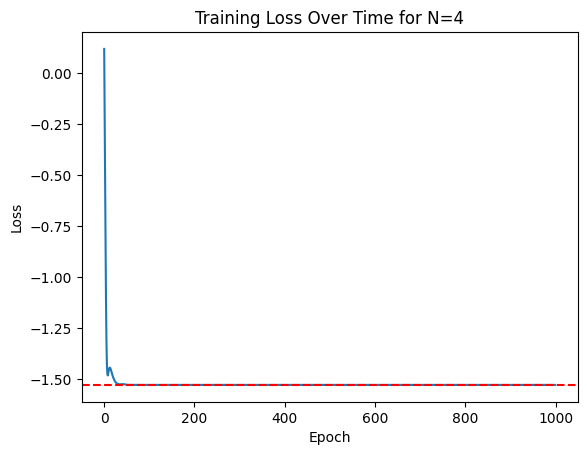

In [54]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=4')
plt.show()

### For N=5 SYK Model

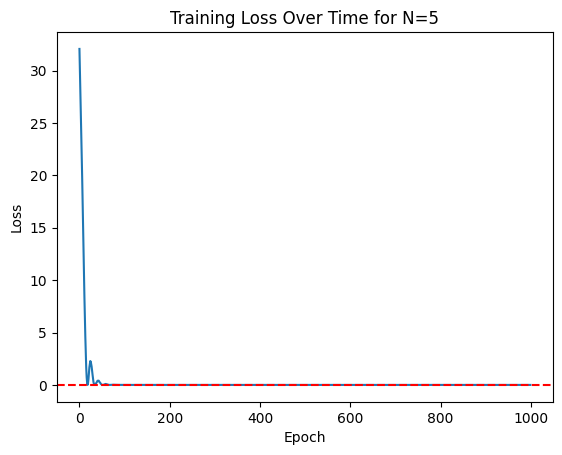

In [9]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=5')
plt.show()

### For N=8 SYK Model

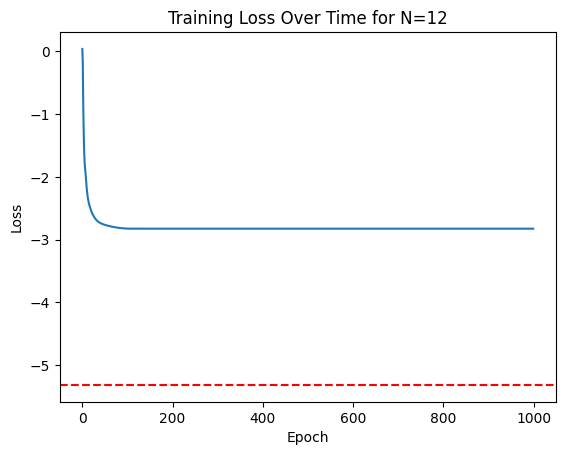

In [87]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=12')
plt.show()

## Sample VQE

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
df= pd.read_csv('SYK_results.csv')
df

,Experiment_run,true_energy,hybrid_model_energy,difference,N
0,experiment_number_0,-5.315575,-2.777270,88.159720,8
1,experiment_number_1,-1.528238,-1.527674,0.039820,4
2,experiment_number_2,-2.745392,-2.095270,31.023244,6
3,experiment_number_3,-2.222125,-1.707276,29.687416,5
4,experiment_number_4,-5.315575,-2.825043,88.158857,8
5,experiment_number_5,-2.222125,-1.713536,29.643425,5
6,experiment_number_6,-1.528238,-1.527714,0.034272,4
7,experiment_number_7,-0.020000,0.000000,inf,2
8,experiment_number_8,-0.030000,-0.030000,0.000003,3
9,experiment_number_9,-1.528238,-1.527714,0.034271,4


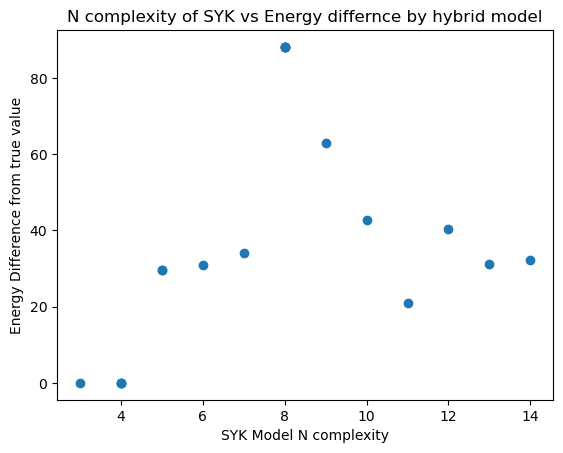

In [10]:
x= df['N']
y= df['difference']
plt.scatter(x,y)
plt.xlabel("SYK Model N complexity")
plt.ylabel("Energy Difference from true value")
plt.title("N complexity of SYK vs Energy differnce by hybrid model")
plt.show()

In [11]:
num_qubits = 8
depth = 4
num_params_per_rotation_layer = 3 * num_qubits
num_params_per_rxx_layer = num_qubits // 2
num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
total_params = depth * num_params_per_layer    

In [12]:
print(total_params)

112


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, ParameterVector

class UnifiedHybridModel(nn.Module):
    def __init__(self, input_dim, output_dim, qubits=4):
        super(UnifiedHybridModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.qubits = qubits

        # A unified parameter vector for both classical and quantum parameters
        self.params = ParameterVector('theta', length=input_dim + qubits + output_dim)

        # Classical-to-Quantum Interface: Maps input_dim to qubits
        self.pre_quantum_layer = nn.Linear(input_dim, qubits)

        # Quantum-to-Classical Interface: Maps qubits to output_dim
        self.post_quantum_layer = nn.Linear(qubits, output_dim)

    def forward(self, x):
        # Classical Encoding
        encoded = self.pre_quantum_layer(x)

        # Quantum Circuit Execution as a 'Layer'
        quantum_output = self.run_quantum_circuit(encoded)

        # Classical Decoding
        decoded = self.post_quantum_layer(quantum_output)
        return decoded

    def run_quantum_circuit(self, params):
        # Define the quantum circuit with parametrized gates
        
        qc = QuantumCircuit(self.qubits)
        paras= []
        for i in params:
            paras.append(i[0])
        for i in range(self.qubits):
            #param_value = params[i].item()
            qc.rx(float(paras[0]), i)


        # Execution and measurement
        backend = Aer.get_backend('statevector_simulator')
        job = execute(qc, backend)
        result = job.result().get_statevector(qc)
        
        # Process the quantum execution result
        # Note: This step may involve more sophisticated processing based on the nature of your problem
        processed_result = self.process_quantum_result(result)
        return processed_result

    def process_quantum_result(self, result):
        # Placeholder for processing the quantum result
        # Convert result to tensor or manipulate as needed
        return torch.tensor([abs(amplitude)**2 for amplitude in result], dtype=torch.float32)

# Example usage
model = UnifiedHybridModel(input_dim=10, output_dim=5).double()
input_data = torch.rand((1, 10), dtype=torch.float32)  # Example input
output = model(input_data)

# Define optimizer and loss for training
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.MSELoss()

# Example training loop (simplified)
for epoch in range(100):
    optimizer.zero_grad()
    output = model(input_data)
    loss = loss_function(output, torch.rand((1, 5), dtype=torch.float32))  # Example target
    loss.backward()
    optimizer.step()


RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double

In [33]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 

import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import MatrixOp
import warnings
from qiskit.circuit.library import RZGate, RXGate, RXXGate
from math import pi

warnings.filterwarnings('ignore')

def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
#hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(len(hamiltonian_matrix))



# Convert the dense Hamiltonian matrix to a suitable operator for VQE
hamiltonian_operator = MatrixOp(hamiltonian_matrix)


# Define a simple parameterized circuit as the ansatz
def create_ansatz(num_qubits):
    depth=4
    # Define the number of parameters for the rotation gates
    num_params_per_rotation_layer = 3 * num_qubits
    # Define the number of parameters for the RXX gates
    num_params_per_rxx_layer = num_qubits // 2
    # Calculate the total number of parameters per layer
    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
    # Calculate the total number of parameters for all layers
    total_params = depth * num_params_per_layer

    # Initialize the parameter vector
    params = ParameterVector('θ', length=total_params)
    # Create the quantum circuit
    qc = QuantumCircuit(num_qubits)
    param_counter = 0  # Counter for the parameters

    # Construct the layers
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            qc.rz(params[param_counter], qubit)
            param_counter += 1
            qc.rx(params[param_counter], qubit)
            param_counter += 1
            qc.rz(params[param_counter], qubit)
            param_counter += 1
        
        # Add the RXX gates for the even layers
        if layer % 2 == 0:
            for qubit in range(0, num_qubits - 1, 2):
                qc.rxx(params[param_counter], qubit, qubit + 1)
                param_counter += 1
        # Add the RXX gates for the odd layers
        else:
            for qubit in range(1, num_qubits - 1, 2):
                qc.rxx(params[param_counter], qubit, qubit + 1)
                param_counter += 1

    return qc, params



num_qubits = int(np.log2(hamiltonian_matrix.shape[0]))
ansatz, parameters = create_ansatz(num_qubits)

# Use SPSA optimizer, it's suitable for noisy optimization like on a real quantum device
optimizer = ADAM(maxiter=1000)

sbo_optimizer = sbovqaopt.optimizer.Optimizer(
            maxiter=1000,
            patch_size=0.1,
            npoints_per_patch=10,
            nfev_final_avg=5
        )

# Setup quantum instance to use the statevector simulator
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# Initialize VQE with the ansatz, optimizer, and the quantum instance
vqe = VQE(ansatz=ansatz, optimizer=sbo_optimizer, quantum_instance=quantum_instance)

# Run VQE to find the lowest eigenvalue of the Hamiltonian
vqe_result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_operator)

# Extract the lowest eigenvaluef
lowest_eigenvalue = np.real(vqe_result.eigenvalue)
print("The VQE given lowest eigenvalue is: ", lowest_eigenvalue)

# Compare to exact solver
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(operator=hamiltonian_operator)

print('Exact Solver Result:', exact_result.eigenvalue.real)


256
The VQE given lowest eigenvalue is:  -3.678399856422667
Exact Solver Result: -5.3155751414376
